# Model

In [406]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.monitor_model import monitor_model
from utils.complete_model_review import complete_model_review

# Read the data - use Numpy for the processed versions since they were also saved with Numpy
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

## Linear Regression Fundamentals

Linear regression is the cornerstone of predictive modeling, representing relationships as straight lines in multi-dimensional space. Think of it as finding the "best-fit line" through a cloud of data points, but extended to handle multiple features simultaneously. The beauty lies in its simplicity: every prediction is just a weighted sum of your input features plus a constant term.

**Why It Matters:**

- **Interpretability**: Every coefficient tells a story about feature impact.
- **Speed**: Trains instantly even on large datasets.
- **Foundation**: Understanding linear regression unlocks advanced techniques.
- **Baseline**: Always start here before trying complex models.


__Author note__: Linear modeling might not be the ideal modeling choice since the dataset is quite complex and has many outliers. Consider exploring more robust algorithms like tree-based methods (e.g., Random Forest, Gradient Boosting) that can better capture non-linear relationships and are less sensitive to outliers.

Score: 1.000


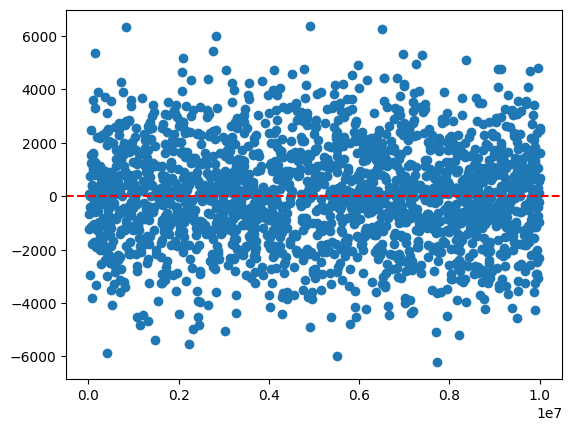

In [407]:
model = LinearRegression()

model.fit(X_train, y_train)

print(f"Score: {model.score(X_test, y_test):.3f}")

residuals = y_test - model.predict(X_test)

plt.scatter(model.predict(X_test), residuals)
plt.axhline(0, color="red", linestyle="--")
plt.show()

## Ridge Regression - Gentle Coefficient Shrinkage

Ridge regression applies a smooth, proportional shrinkage to all coefficients. Imagine gradually turning down the volume on all features equally - none disappear completely, but their influence diminishes based on the regularization strength. This makes Ridge particularly effective when you believe all features contribute something valuable.

**Ridge Characteristics:**

- **Conservative approach**: Keeps all features in the model.
- **Handles multicollinearity**: Correlated features share the burden.
- **Smooth shrinkage**: Coefficients approach zero gradually.
- **Stable results**: Less sensitive to small data changes.

In [408]:
ridge = RidgeCV(alphas=[0.1, 1, 10, 100])  # Auto-selects best alpha
ridge.fit(X_train, y_train)
print(f"Best alpha: {ridge.alpha_}")

grid = GridSearchCV(Ridge(), {"alpha": [0.1, 1, 10, 100]}, cv=5)
grid.fit(X_train, y_train)
print(f"Best alpha: {grid.best_params_}")

Best alpha: 0.1
Best alpha: {'alpha': 0.1}


In [409]:
models = {
    "Linear": LinearRegression(),
    "Ridge": RidgeCV(alphas=[10]),
    "Lasso": LassoCV(max_iter=10000),
}
for name, model in models.items():
    model.fit(X_train, y_train["price"])

    score = cross_val_score(
        model, X_train, y_train["price"], cv=5
    ).mean()
    print(f"{name}: {score:.3f}")

Linear: 1.000
Ridge: 1.000
Lasso: 1.000


## Performance Metrics Deep Dive

Different metrics tell different stories about your model's performance. R² measures explanatory power, RMSE penalizes large errors more heavily, and MAE treats all errors equally. Understanding when to use each metric helps you evaluate models appropriately for your specific use case.

**Metric Characteristics:**

- R² (0-1): Proportion of variance explained; higher is better.
- RMSE: Root mean squared error; same units as target; penalizes outliers.
- MAE: Mean absolute error; robust to outliers; intuitive interpretation.

**Choosing the Right Metric:**

- R²: When you want to understand explanatory power.
- RMSE: When large errors are particularly costly.
- MAE: When all errors are equally important.

In [410]:
for name, model in models.items():
    y_pred = model.predict(X_test)

    print(f"{name}: R²: {r2_score(y_test, y_pred):.3f}")
    print(f"{name}: RMSE: {mean_squared_error(y_test, y_pred)**0.5:.3f}")
    print(f"{name}: MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print("\n")

Linear: R²: 1.000
Linear: RMSE: 1922.423
Linear: MAE: 1510.034


Ridge: R²: 1.000
Ridge: RMSE: 11031.404
Ridge: MAE: 9568.020


Lasso: R²: 1.000
Lasso: RMSE: 4420.073
Lasso: MAE: 3590.032




## Learning Curves for Model Diagnosis

Learning curves reveal your model's learning behavior as training data increases. They help diagnose whether you need more data, simpler models, or better features. Think of them as growth charts for your model - they show whether performance plateaus or continues improving with more examples.

**Curve Interpretation:**

- Converging curves at high performance: Good fit.
- Large gap between train/validation: Overfitting (high variance).
- Both curves plateau at low performance: Underfitting (high bias).
- Validation curve still improving: More data would help.

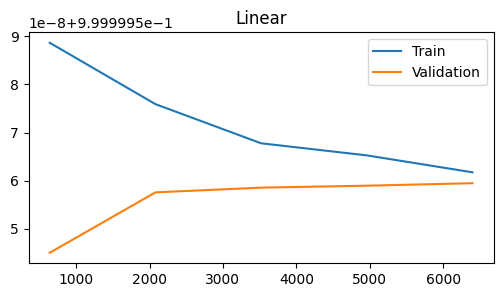

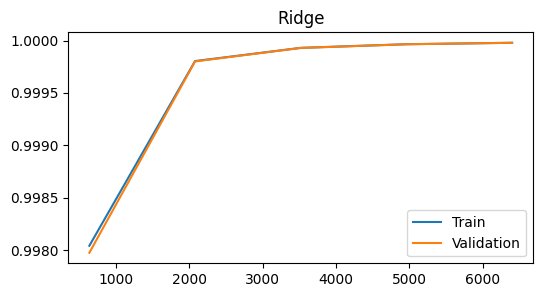

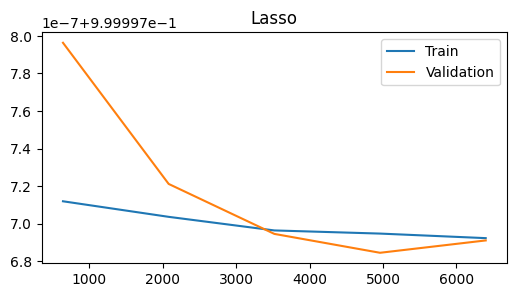

In [411]:
for name, model in models.items():
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train["price"], cv=5
    )
    plt.figure(figsize=(6, 3))
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
    plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
    plt.legend()
    plt.title(name)
    plt.show()

## Understanding Coefficients: The Building Blocks

**💡 Concept:** Coefficients are the heart of any regression model, representing the mathematical relationships between predictors and the target variable. Each coefficient tells you how much the dependent variable is expected to change for a one-unit increase in the corresponding independent variable, while holding all other variables constant. This "ceteris paribus" condition is crucial—it means the coefficient represents the isolated effect of that variable.

**Coefficient Magnitude and Practical Significance:** The size of a coefficient doesn't automatically indicate importance. A small coefficient might represent a practically significant effect if the predictor variable has a large range, while a large coefficient might be practically meaningless if the predictor rarely varies. Always consider the coefficient in context of the variable's typical range and measurement scale.

**Key Points:**
- **Positive coefficient** = as input increases, output increases
- **Negative coefficient** = as input increases, output decreases
- **Larger absolute value** = stronger effect

In [412]:
# Look at coefficients
features = X_train.columns
coefficients = models["Ridge"].coef_

for feature, coef in zip(features, coefficients):
    print(f"{feature}: {coef:.3f}")
    if coef > 0:
        print("  → Positive effect")
    else:
        print("  → Negative effect")

squareMeters: 4878526.840
  → Positive effect
numberOfRooms: 133.842
  → Positive effect
hasYard: 3066.716
  → Positive effect
hasPool: 2608.947
  → Positive effect
floors: 2728.034
  → Positive effect
cityCode: -7.021
  → Negative effect
cityPartRange: 384.792
  → Positive effect
numPrevOwners: 290.134
  → Positive effect
made: -177.677
  → Negative effect
isNewBuilt: -59.546
  → Negative effect
hasStormProtector: 201.404
  → Positive effect
basement: -33.080
  → Negative effect
attic: -22.030
  → Negative effect
garage: -269.670
  → Negative effect
hasStorageRoom: -198.201
  → Negative effect
hasGuestRoom: -34.696
  → Negative effect


## Residuals - Your Model's Mistakes

**Enhanced Conceptual Framework:** Residuals are the "DNA" of your regression model. They contain all the information about what your model couldn't explain. Each residual represents the difference between what actually happened and what your model predicted. More than just error measurements, residuals reveal patterns that can guide model improvement, identify outliers, and validate assumptions.

**Residual Patterns and Their Meanings:** Random scatter around zero indicates a well-specified model. Curved patterns suggest non-linear relationships that the model isn't capturing. Funnel shapes indicate heteroscedasticity (changing variance). Systematic patterns might reveal missing variables or incorrect functional forms.

In [413]:
# Calculate residuals
for name, model in models.items():
    predictions = model.predict(X_test)
    residuals = y_test["price"] - predictions

    print(f"Residual Analysis for {name}:")
    print(f"- Average residual: {residuals.mean():.3f}")
    print(f"- Largest error: {abs(residuals).max():.3f}")
    print(f"- Standard deviation: {residuals.std():.3f}")
    print("\n")

Residual Analysis for Linear:
- Average residual: 25.134
- Largest error: 6364.131
- Standard deviation: 1922.739


Residual Analysis for Ridge:
- Average residual: 577.556
- Largest error: 23325.203
- Standard deviation: 11019.030


Residual Analysis for Lasso:
- Average residual: 226.020
- Largest error: 14214.635
- Standard deviation: 4415.395




In [414]:
for name, model in models.items():
    r2 = model.score(X_test, y_test)

    print(f"{name}: R-squared: {r2:.3f}")
    print(f"{name}: Model explains {r2*100:.1f}% of the variation")

    if r2 > 0.7:
        print("✅ Good model!")
    elif r2 > 0.5:
        print("⚠️ Okay model")
    else:
        print("❌ Needs improvement")

Linear: R-squared: 1.000
Linear: Model explains 100.0% of the variation
✅ Good model!
Ridge: R-squared: 1.000
Ridge: Model explains 100.0% of the variation
✅ Good model!
Lasso: R-squared: 1.000
Lasso: Model explains 100.0% of the variation
✅ Good model!


## Checking If Your Model Makes Sense

**Theoretical Framework:** Linear regression relies on several key assumptions that must be validated for reliable results. These assumptions include linearity (relationship between X and Y is linear), independence (observations are independent), homoscedasticity (constant variance of residuals), and normality (residuals are normally distributed). Violating these assumptions can lead to biased estimates and unreliable predictions.

**Visual Diagnostic Approach:** Visual diagnostics are often more intuitive than statistical tests for assumption checking. Plots can reveal patterns that statistical tests might miss, and they provide immediate feedback about the nature and severity of assumption violations.

In [415]:
features = ["squareMeters", "numberOfRooms"]
expected_signs = ["+", "+", "+", "+", "+", "+"]  # All should increase price

for feature, coef, expected in zip(features, model.coef_, expected_signs):
    actual_sign = "+" if coef > 0 else "-"
    match = "✅" if actual_sign == expected else "❌"
    print(f"{feature}: {actual_sign} {match}")

squareMeters: + ✅
numberOfRooms: - ❌


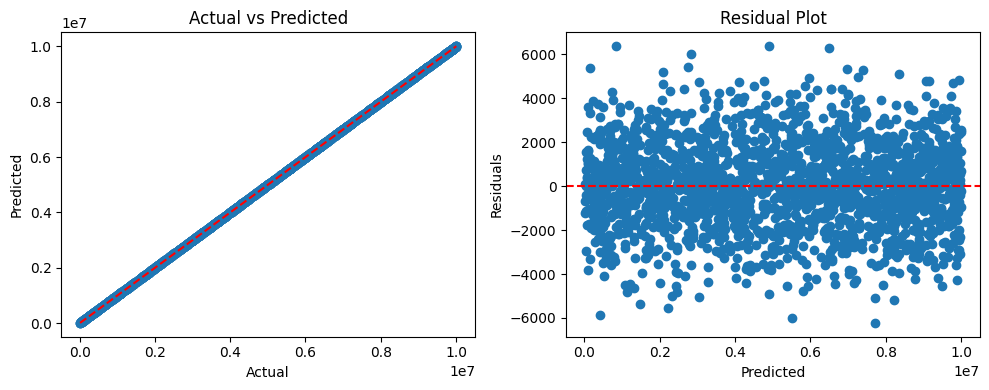

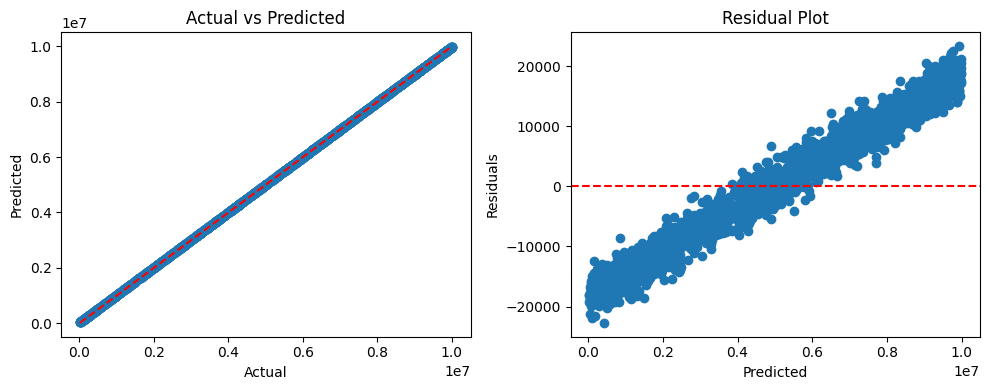

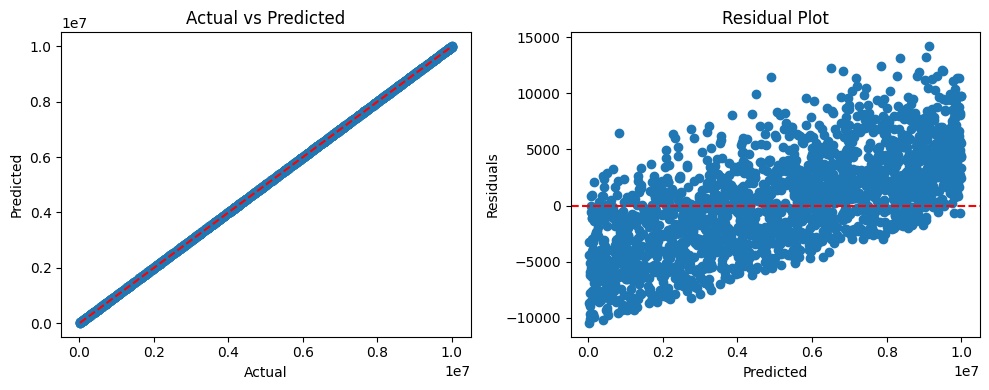

In [416]:
for name, model in models.items():
    # Simple diagnostic plots
    predictions = model.predict(X_test)
    residuals = y_test["price"] - predictions

    # Plot 1: Actual vs Predicted
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, predictions)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")

    # Plot 2: Residuals
    plt.subplot(1, 2, 2)
    plt.scatter(predictions, residuals)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")

    plt.tight_layout()
    plt.show()

In [417]:
features = X_train.columns
coefficients = models["Ridge"].coef_

print("MODEL EXPLANATION FOR STAKEHOLDERS")
print("=" * 40)
print(f"Model accuracy: {models['Ridge'].score(X_test, y_test)*100:.0f}%")
print("\nKey findings:")

for feature, coef in zip(features, coefficients):
    if coef > 0:
        print(f"• {feature}: +{coef:.3f} impact per unit increase")
    else:
        print(f"• {feature}: {coef:.3f} impact per unit increase")

print(f"\nTypical prediction error: ±${abs(residuals).mean():.3f}")

MODEL EXPLANATION FOR STAKEHOLDERS
Model accuracy: 100%

Key findings:
• squareMeters: +4878526.840 impact per unit increase
• numberOfRooms: +133.842 impact per unit increase
• hasYard: +3066.716 impact per unit increase
• hasPool: +2608.947 impact per unit increase
• floors: +2728.034 impact per unit increase
• cityCode: -7.021 impact per unit increase
• cityPartRange: +384.792 impact per unit increase
• numPrevOwners: +290.134 impact per unit increase
• made: -177.677 impact per unit increase
• isNewBuilt: -59.546 impact per unit increase
• hasStormProtector: +201.404 impact per unit increase
• basement: -33.080 impact per unit increase
• attic: -22.030 impact per unit increase
• garage: -269.670 impact per unit increase
• hasStorageRoom: -198.201 impact per unit increase
• hasGuestRoom: -34.696 impact per unit increase

Typical prediction error: ±$3590.032


In [426]:
# Simple assumption checks
predictions = models["Linear"].predict(X_test)
residuals = y_test["price"] - predictions

print("ASSUMPTION CHECKS")
print("=" * 20)

# Check 1: Linear relationship
correlation = np.corrcoef(predictions, residuals)[0, 1]
if abs(correlation) < 0.1:
    print("✅ Linear relationship looks good")
else:
    print("⚠️ May need non-linear terms")

# Check 2: Residual distribution
if abs(residuals.mean()) < 0.1:
    print("✅ Residuals centered at zero")
else:
    print(f"⚠️ Model may be biased - Residuals means: {residuals.mean():.3f}")

# Check 3: Outliers
outlier_count = sum(abs(residuals) > 2 * residuals.std())
if outlier_count < len(residuals) * 0.05:
    print("✅ Few outliers detected")
else:
    print("⚠️ Many outliers - check data quality")

ASSUMPTION CHECKS
✅ Linear relationship looks good
⚠️ Model may be biased - Residuals means: 25.134
✅ Few outliers detected


In [427]:
# Test model on different data subsets
cv_scores = cross_val_score(models["Linear"], X_train, y_train, cv=5)

print("CROSS-VALIDATION RESULTS")
print("=" * 40)
print(f"Individual scores: {cv_scores}")
print(f"Average score: {cv_scores.mean():.3f}")
print(f"Standard deviation: {cv_scores.std():.3f}")

# Interpretation
if cv_scores.std() < 0.1:
    print("✅ Model performance is consistent")
else:
    print("⚠️ Model performance varies significantly")

if cv_scores.mean() > 0.7:
    print("✅ Good average performance")
else:
    print("⚠️ Performance needs improvement")

CROSS-VALIDATION RESULTS
Individual scores: [0.99999958 0.99999956 0.99999955 0.99999956 0.99999955]
Average score: 1.000
Standard deviation: 0.000
✅ Model performance is consistent
✅ Good average performance


In [428]:
for _, model in models.items():
    monitor_model(model, X_test, y_test["price"])
    print("\n")

MODEL MONITORING REPORT
Current R²: 1.000
Average error: 1510.034
Max error: 6364.131
✅ Model performing well


MODEL MONITORING REPORT
Current R²: 1.000
Average error: 9568.020
Max error: 23325.203
✅ Model performing well


MODEL MONITORING REPORT
Current R²: 1.000
Average error: 3590.032
Max error: 14214.635
✅ Model performing well




## Complete Model Review Checklist:

- ✅ Check R² and prediction accuracy.
- ✅ Examine coefficients for business sense.
- ✅ Analyze residuals for patterns.
- ✅ Test key assumptions.
- ✅ Validate with cross-validation.
- ✅ Create clear explanations for stakeholders.
- ✅ Set up monitoring plan.

In [429]:
for _, model in models.items():
    complete_model_review(
        models["Ridge"], X_test, y_test["price"], X_test.columns
    )

COMPLETE MODEL REVIEW
1. Performance: R² = 1.000
2. Coefficients:
   squareMeters: 4878526.840
   numberOfRooms: 133.842
   hasYard: 3066.716
   hasPool: 2608.947
   floors: 2728.034
   cityCode: -7.021
   cityPartRange: 384.792
   numPrevOwners: 290.134
   made: -177.677
   isNewBuilt: -59.546
   hasStormProtector: 201.404
   basement: -33.080
   attic: -22.030
   garage: -269.670
   hasStorageRoom: -198.201
   hasGuestRoom: -34.696
3. Residuals: Mean = 577.556
4. Outliers: 4 found

5. OVERALL ASSESSMENT:
   ⚠️ Model needs improvement
COMPLETE MODEL REVIEW
1. Performance: R² = 1.000
2. Coefficients:
   squareMeters: 4878526.840
   numberOfRooms: 133.842
   hasYard: 3066.716
   hasPool: 2608.947
   floors: 2728.034
   cityCode: -7.021
   cityPartRange: 384.792
   numPrevOwners: 290.134
   made: -177.677
   isNewBuilt: -59.546
   hasStormProtector: 201.404
   basement: -33.080
   attic: -22.030
   garage: -269.670
   hasStorageRoom: -198.201
   hasGuestRoom: -34.696
3. Residuals: Mean =